In [154]:
# Data Processing
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(3)

In [155]:
def train_and_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # Train the model
    predictions = model.predict(X_test) # Make predictions on the test set

    # Removing negative values in predictions
    mask = predictions >= 0
    predictions = predictions[mask]
    y_test = y_test[mask]
    r2 = r2_score(y_test, predictions)
    return predictions, y_test

In [156]:

def print_stats(y_test, predictions):
    print('Mean Squared Error (MSE):', mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, predictions)))
    mape = np.mean(np.abs((y_test - predictions) / np.abs(y_test)))
    print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
    print('Accuracy:', round(100 * (1 - mape), 2))

    correlation_coefficient, p_value = spearmanr(y_test, predictions)
    print(f"\nSpearman Rho:{correlation_coefficient}\np-value:{p_value}")

In [157]:

def merge_identical_xlsx_columns(df, col_name1, col_name2, merged_col_name):
    df[merged_col_name] = df[col_name1].fillna(df[col_name2])
    if merged_col_name == col_name1:
        df.drop(col_name2, axis=1, inplace=True)
    elif merged_col_name == col_name2:
        df.drop(col_name1, axis=1, inplace=True)
    else:
        df.drop([col_name1, col_name2], axis=1, inplace=True)
    return df

Load and Clean Data

In [158]:
# Load original clinical data file
df = pd.read_csv('./DATA/ccle_broad_2019_clinical_data.csv')
df

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
0,ccle_broad_2019,127399_SOFT_TISSUE,127399_SOFT_TISSUE,NaN,NaN,Soft Tissue Sarcoma,Synovial Sarcoma,NaN,NaN,ACH-001270,...,NaN,NaN,NaN,NaN,NaN,Synovial,NaN,5.533333,NaN,NaN
1,ccle_broad_2019,1321N1_CENTRAL_NERVOUS_SYSTEM,1321N1_CENTRAL_NERVOUS_SYSTEM,NaN,CCLE,Glioma,Astrocytoma,NaN,NaN,ACH-001000,...,NaN,NaN,brain,NS,NS,Astrocytoma,NaN,NaN,glioma,glioma
2,ccle_broad_2019,143B_BONE,143B_BONE,13.0,CCLE,Bone Cancer,Osteosarcoma,NaN,NaN,ACH-001001,...,Female,NaN,NS,NS,NS,Osteosarcoma,NaN,NaN,osteosarcoma,osteosarcoma
3,ccle_broad_2019,201T_LUNG,201T_LUNG,NaN,NaN,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,ACH-002089,...,NaN,NaN,NaN,NaN,NaN,"Non-Small Cell Lung Cancer (NSCLC), Adenocarci...",NaN,10.100000,NaN,lung_NSC
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,ccle_broad_2019,YMB1_BREAST,YMB1_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,NaN,NaN,ACH-001249,...,Female,NaN,NS,NS,NS,Carcinoma,NaN,NaN,breast,breast
1735,ccle_broad_2019,YT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,T-Lymphoblastic Leukemia/Lymphoma,Natural Killer (NK) Cell Lymphoblastic Leukemi...,NaN,NaN,ACH-002317,...,NaN,NaN,NaN,NaN,NaN,Natural Killer Cell Lymphoblastic Leukemia/Lym...,NaN,18.200000,NaN,NaN
1736,ccle_broad_2019,Z138_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Z138_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Mature B-Cell Neoplasms,Mantle Cell Lymphoma,NaN,NaN,ACH-002500,...,NaN,NaN,NaN,NaN,NaN,"B-cell, Non-Hodgkins, Mantle Cell",NaN,NaN,NaN,NaN
1737,ccle_broad_2019,ZR751_BREAST,ZR751_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,ATCC,adherent epithelial,ACH-000097,...,Female,ascites,NS,NS,NS,Breast Ductal Carcinoma,NaN,8.500000,breast,breast


In [159]:
# Load second clinical data file
df2 = pd.read_excel('./DATA/merged_doubling_time_with_site.xlsx')
df2 = merge_identical_xlsx_columns(df2, "CCLE Doubling Time (hrs)","Doubling.Time.Calculated.hrs",
                                    "CCLE Doubling Time (hrs)")

df2

,Parental cell line ID,Cell Line Name,GPP (screeners) Cell Doubling Time (hrs),DepMap expansion Doubling time (hrs),CCLE Doubling Time (hrs),Site_Primary
0,ACH-000014,Hs294T,66.0,NaN,67.5,skin
1,ACH-000021,NCIH1693,50.0,NaN,94.7,lung
2,ACH-000022,PATU8988S,36.0,NaN,110.0,pancreas
3,ACH-000025,CH157MN,35.0,NaN,NaN,central_nervous_system
4,ACH-000037,S117,45.0,NaN,107.6,soft_tissue
...,...,...,...,...,...,...
1252,ACH-002994,WSUAML,53.0,NaN,NaN,NaN
1253,ACH-003016,TELOHAEC,48.0,NaN,NaN,NaN
1254,ACH-003019,LASCPC01,27.0,NaN,NaN,NaN
1255,ACH-003065,CHLA02ATRT,72.0,NaN,NaN,NaN


In [160]:
# merge only CCLE data
for index, row in df2.iterrows():
    matching_row = df[df['DepMap ID'] == row['Parental cell line ID']]
    if not matching_row.empty:
        df.loc[matching_row.index, 'Doubling Time (hrs)'] = row['CCLE Doubling Time (hrs)']

df_cleaned = df.dropna(subset=['Doubling Time (hrs)']) # Clean 'NA' labels
patient_IDs = df_cleaned["Patient ID"].tolist() # who was left after cleaning NA
patient_IDs

['22RV1_PROSTATE',
 '2313287_STOMACH',
 '42MGBA_CENTRAL_NERVOUS_SYSTEM',
 '5637_URINARY_TRACT',
 '59M_OVARY',
 '639V_URINARY_TRACT',
 '647V_URINARY_TRACT',
 '697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 '769P_KIDNEY',
 '8305C_THYROID',
 '8505C_THYROID',
 '8MGBA_CENTRAL_NERVOUS_SYSTEM',
 'A101D_SKIN',
 'A172_CENTRAL_NERVOUS_SYSTEM',
 'A2058_SKIN',
 'A253_SALIVARY_GLAND',
 'A2780_OVARY',
 'A375_SKIN',
 'A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'A498_KIDNEY',
 'A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'A549_LUNG',
 'ABC1_LUNG',
 'ACHN_KIDNEY',
 'AGS_STOMACH',
 'ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'AN3CA_ENDOMETRIUM',
 'ASPC1_PANCREAS',
 'AU565_BREAST',
 'BC3C_URINARY_TRACT',
 'BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'BCPAP_THYROID',
 'BECKER_CENTRAL_NERVOUS_SYSTEM',
 'BEN_LUNG',
 'BFTC905_URINARY_TRACT',
 'BFTC909_KIDNEY',
 'BHT101_THYROID',
 'BHY_UPPER_AERODIGESTIVE_TRACT',
 'BICR16_U

In [161]:
# Load RNA expression data (use Reads Per Kilobase data)
expression_df = pd.read_csv('./DATA/ccle_broad_2019/data_mrna_seq_rpkm.txt',  sep='\t')
expression_df

,Hugo_Symbol,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,...,UMUC16_URINARY_TRACT,UMUC4_URINARY_TRACT,UMUC5_URINARY_TRACT,UMUC6_URINARY_TRACT,UMUC7_URINARY_TRACT,UMUC9_URINARY_TRACT,UPCISCC152_UPPER_AERODIGESTIVE_TRACT,UW228_CENTRAL_NERVOUS_SYSTEM,Y79_AUTONOMIC_GANGLIA,YAMATO_SOFT_TISSUE
0,DDX11L1,0.00000,0.03755,0.00000,0.06507,0.00000,0.01378,0.01463,0.03085,0.00000,...,0.00000,0.02977,0.02999,0.03532,0.03831,0.03236,0.00000,0.03799,0.02907,0.00000
1,WASH7P,12.63011,10.14155,6.20657,6.55835,7.61752,6.19356,4.62277,6.00767,4.70699,...,6.42321,8.17443,7.75149,9.97036,8.17080,8.70551,15.23348,6.47732,8.45568,11.81688
2,MIR1302-11,0.04289,0.01037,0.16955,0.23364,0.08765,0.00000,0.00808,0.09373,0.02568,...,0.12367,0.19183,0.10492,0.18537,0.07408,0.07747,0.07448,0.01049,0.39607,0.17586
3,FAM138A,0.00000,0.00869,0.22423,0.16558,0.00000,0.00637,0.00000,0.01427,0.00000,...,0.01554,0.00459,0.01850,0.04903,0.01330,0.00000,0.02674,0.00879,0.26449,0.02266
4,OR4G4P,0.00000,0.00000,0.02886,0.03875,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00667,0.01182,0.01786,0.01052,0.01141,0.00642,0.00000,0.00000,0.00000,0.01459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56313,MT-ND5,2393.80298,1960.96802,1896.28870,3522.37695,1178.93579,1345.42151,1943.89148,1413.57471,956.31226,...,1994.84985,704.86267,3936.23853,3560.20459,1245.38379,1452.41895,793.58710,757.41357,1218.16992,1320.84558
56314,MT-ND6,1825.52332,2056.64697,2184.88647,4568.00195,1616.96484,1189.86279,1906.90405,1469.75574,1151.82861,...,1260.28455,398.13406,2419.38281,1791.45386,823.17352,996.53717,593.61139,472.01627,729.65912,564.16779
56315,MT-TE,0.25386,0.00000,0.26410,0.00000,0.12970,0.00000,0.00000,0.25217,0.00000,...,1.28093,0.40550,1.22567,1.58799,1.40931,0.08817,0.31489,0.15526,0.55439,0.00000
56316,MT-CYB,4923.78223,3827.00537,1905.18481,4590.01416,2343.92407,1902.01685,2026.15710,1603.98230,2752.73779,...,1585.35229,2027.31738,8521.06738,10211.49121,1641.64551,3437.12769,1645.22168,973.56439,1221.39954,1755.82764


In [162]:
# Remove patients with NA Doubling Time
selected_columns = ['Hugo_Symbol'] + [col for col in patient_IDs if col in expression_df.columns]
expression_df = expression_df[selected_columns]
print(expression_df.head())

  Hugo_Symbol  22RV1_PROSTATE  2313287_STOMACH  42MGBA_CENTRAL_NERVOUS_SYSTEM  \
0     DDX11L1         0.00000          0.03755                        0.00000   
1      WASH7P        12.63011         10.14155                        7.61752   
2  MIR1302-11         0.04289          0.01037                        0.08765   
3     FAM138A         0.00000          0.00869                        0.00000   
4      OR4G4P         0.00000          0.00000                        0.00000   

   5637_URINARY_TRACT  59M_OVARY  639V_URINARY_TRACT  647V_URINARY_TRACT  \
0             0.01378    0.01463             0.03085             0.00000   
1             6.19356    4.62277             6.00767             4.70699   
2             0.00000    0.00808             0.09373             0.02568   
3             0.00637    0.00000             0.01427             0.00000   
4             0.00000    0.00000             0.00000             0.00000   

   697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE  769P_KIDNEY  

In [163]:
 # sort by patient ID
expression_df_sorted = expression_df[expression_df.columns[0]].to_frame().join(expression_df[expression_df.columns[1:]].sort_index(axis=1))
df_cleaned_sorted = df_cleaned.sort_values(by='Patient ID')
df_cleaned_sorted

,Study ID,Patient ID,Sample ID,Age,Annotation Source,Cancer Type,Cancer Type Detailed,Cell Line Source,Characteristics,DepMap ID,...,Sex,Site of Finding,Site Subtype 1,Site Subtype 2,Site Subtype 3,Subtype,Supplements,TMB (nonsynonymous),Tumor Type,Type Refined
4,ccle_broad_2019,22RV1_PROSTATE,22RV1_PROSTATE,NaN,CCLE,Prostate Cancer,Prostate Adenocarcinoma,ATCC,Adherent epithelial,ACH-000956,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,73.700000,prostate,prostate
5,ccle_broad_2019,2313287_STOMACH,2313287_STOMACH,72.0,CCLE,Esophagogastric Cancer,Stomach Adenocarcinoma,DSMZ,aderent epithelial cells growing as confluent ...,ACH-000948,...,Male,NaN,NS,NS,NS,Adenocarcinoma,NaN,76.266667,stomach,stomach
8,ccle_broad_2019,42MGBA_CENTRAL_NERVOUS_SYSTEM,42MGBA_CENTRAL_NERVOUS_SYSTEM,63.0,CCLE,Glioma,Astrocytoma,DSMZ,Adherent,ACH-000323,...,Male,NaN,brain,NS,NS,Astrocytoma,NaN,7.033333,glioma,glioma
10,ccle_broad_2019,5637_URINARY_TRACT,5637_URINARY_TRACT,68.0,CCLE,Bladder Cancer,Bladder Urothelial Carcinoma,NaN,adherent,ACH-000905,...,Male,NaN,bladder,NS,NS,NaN,NaN,15.366667,urinary_tract,urinary_tract
11,ccle_broad_2019,59M_OVARY,59M_OVARY,NaN,CCLE,Ovarian Cancer,High-Grade Serous Ovarian Cancer,ECACC,NaN,ACH-000520,...,Female,ascites,NS,NS,NS,"Adenocarcinoma, high grade serous",NaN,7.500000,ovary,ovary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,ccle_broad_2019,YD15_SALIVARY_GLAND,YD15_SALIVARY_GLAND,39.0,CCLE,Salivary Gland Cancer,Mucoepidermoid Carcinoma,KCLB,epithelial; monolayer,ACH-000836,...,Male,NaN,tongue,NS,NS,"Squamous Cell Carcinoma, tongue",25mM Hepes and 25mM NaHCo3,5.933333,other,upper_aerodigestive
1731,ccle_broad_2019,YH13_CENTRAL_NERVOUS_SYSTEM,YH13_CENTRAL_NERVOUS_SYSTEM,40.0,CCLE,Glioma,Glioblastoma Multiforme,HSSRB,Adherent,ACH-000469,...,Male,NaN,brain,NS,NS,Glioblastoma,NaN,8.066667,glioma,glioma
1732,ccle_broad_2019,YKG1_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,NaN,CCLE,Glioma,Glioblastoma Multiforme,GNF,NaN,ACH-000570,...,Female,NaN,temporal_lobe,NS,NS,Glioblastoma,NaN,12.066667,glioma,glioma
1737,ccle_broad_2019,ZR751_BREAST,ZR751_BREAST,63.0,CCLE,Breast Cancer,Invasive Breast Carcinoma,ATCC,adherent epithelial,ACH-000097,...,Female,ascites,NS,NS,NS,Breast Ductal Carcinoma,NaN,8.500000,breast,breast


In [164]:
# Get all column names except for the first one and store them in a list
patient_ID_list = expression_df_sorted.columns[1:].tolist()

# Filter out rows where 'Patient ID' is not in the allowed list
df_cleaned_sorted_filtered = df_cleaned_sorted[df_cleaned_sorted['Patient ID'].isin(patient_ID_list)]

num_rows, num_columns = df_cleaned_sorted_filtered.shape
print(f'Successfully loaded data.\nNumber of rows:{num_rows}\nNumber of columns:{num_columns-1}')
print(df_cleaned_sorted_filtered.head())

Successfully loaded data.
Number of rows:713
Number of columns:50
           Study ID                     Patient ID  \
4   ccle_broad_2019                 22RV1_PROSTATE   
5   ccle_broad_2019                2313287_STOMACH   
8   ccle_broad_2019  42MGBA_CENTRAL_NERVOUS_SYSTEM   
10  ccle_broad_2019             5637_URINARY_TRACT   
11  ccle_broad_2019                      59M_OVARY   

                        Sample ID   Age Annotation Source  \
4                  22RV1_PROSTATE   NaN              CCLE   
5                 2313287_STOMACH  72.0              CCLE   
8   42MGBA_CENTRAL_NERVOUS_SYSTEM  63.0              CCLE   
10             5637_URINARY_TRACT  68.0              CCLE   
11                      59M_OVARY   NaN              CCLE   

               Cancer Type              Cancer Type Detailed Cell Line Source  \
4          Prostate Cancer           Prostate Adenocarcinoma             ATCC   
5   Esophagogastric Cancer            Stomach Adenocarcinoma             DSMZ   

In [165]:
# Prepare counts
counts = expression_df_sorted
counts = counts.set_index('Hugo_Symbol')
counts = counts[counts.sum(axis=1) > 0]   #remove rows containing only 0

# Transpose the DataFrame to have samples as rows and genes as columns
counts = counts.T #(=x.train)

# prepare metadata (=y.train)
metadata = pd.DataFrame(zip(counts.index, df_cleaned_sorted_filtered['Doubling Time (hrs)']),
                        columns=['Sample', 'Doubling Time (hrs)'])
metadata = metadata.set_index('Sample')
metadata

,Doubling Time (hrs)
Sample,
22RV1_PROSTATE,58.400000
2313287_STOMACH,97.600000
42MGBA_CENTRAL_NERVOUS_SYSTEM,82.600000
5637_URINARY_TRACT,60.900000
59M_OVARY,113.118025
...,...
YD15_SALIVARY_GLAND,28.844032
YH13_CENTRAL_NERVOUS_SYSTEM,77.100000
YKG1_CENTRAL_NERVOUS_SYSTEM,35.800000


Get Features (Genes)

In [166]:
genes, rhos, pvals = [], [], []
# Loop through each gene column
for gene_idx in range(counts.shape[1]):
    # Extract the gene expression levels for the current gene
    gene_expression = counts.iloc[:, gene_idx].tolist()

    # Calculate correlation and p-value
    correlation_coefficient, p_value = pearsonr(gene_expression, metadata['Doubling Time (hrs)'].tolist())

    if abs(correlation_coefficient) >= 0.38 and p_value <= 0.05:
        genes.append(counts.columns[gene_idx])
        pvals.append(p_value)
        rhos.append(correlation_coefficient)

chosen_genes_expression = counts[counts.columns[counts.columns.isin(genes)]]
chosen_genes_expression

# add the doubling time as a column in the df
#chosen_genes_expression['Doubling Time (hrs)'] = metadata['Doubling Time (hrs)']

Hugo_Symbol,FAM41C,SNORA77,SNORA77,SNORA77,SNORA77,SNORA77,RN7SL503P,MANEAL,SNORA77,SNORA77,...,SNORA77,SNORA77,GFRA4,SNORA77,SNORA77,SNORA77,SNORA77,SNORA77,LUZP4,NAP1L1P2
22RV1_PROSTATE,0.04888,0.00000,0.00000,0.0,0.0,0.84079,0.05858,21.30927,0.00000,0.00000,...,0.0,0.84079,0.00000,0.00000,0.00000,0.0,0.0,0.84079,0.0,0.04825
2313287_STOMACH,0.02149,0.00000,0.00000,0.0,0.0,0.42360,0.00000,4.13702,0.00000,0.00000,...,0.0,0.42360,0.00000,0.00000,0.00000,0.0,0.0,0.42360,0.0,0.09724
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.04541,0.07159,0.00000,0.0,0.0,0.35797,0.00000,7.03966,0.07159,0.00000,...,0.0,0.35797,0.00000,0.07159,0.00000,0.0,0.0,0.35797,0.0,0.00000
5637_URINARY_TRACT,0.00789,0.00000,0.12434,0.0,0.0,0.49734,0.00000,14.91884,0.00000,0.12434,...,0.0,0.49734,0.00000,0.00000,0.12434,0.0,0.0,0.49734,0.0,0.00000
59M_OVARY,0.05441,0.00000,0.13199,0.0,0.0,0.06599,0.00000,0.20773,0.00000,0.13199,...,0.0,0.06599,0.00000,0.00000,0.13199,0.0,0.0,0.06599,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YD15_SALIVARY_GLAND,0.28284,0.00000,0.00000,0.0,0.0,0.00000,0.00000,10.94803,0.00000,0.00000,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.03938
YH13_CENTRAL_NERVOUS_SYSTEM,0.04253,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.50686,0.00000,0.00000,...,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.00000
YKG1_CENTRAL_NERVOUS_SYSTEM,0.00488,0.00000,0.07700,0.0,0.0,0.61600,0.00000,9.06363,0.00000,0.07700,...,0.0,0.61600,0.00000,0.00000,0.07700,0.0,0.0,0.61600,0.0,0.00000
ZR751_BREAST,0.00000,0.00000,0.00000,0.0,0.0,1.94427,0.75030,7.73689,0.00000,0.00000,...,0.0,1.94427,0.03697,0.00000,0.00000,0.0,0.0,1.94427,0.0,0.00000


Train Models and Predict

In [167]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(chosen_genes_expression, metadata['Doubling Time (hrs)'], test_size=0.2, random_state=42)

In [202]:
X_train

Hugo_Symbol,FAM41C,SNORA77,SNORA77,SNORA77,SNORA77,SNORA77,RN7SL503P,MANEAL,SNORA77,SNORA77,...,SNORA77,SNORA77,GFRA4,SNORA77,SNORA77,SNORA77,SNORA77,SNORA77,LUZP4,NAP1L1P2
KARPAS620_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.05507,0.0,0.00000,0.0,0.0,0.69463,0.00000,14.26997,0.0,0.00000,...,0.0,0.69463,0.0,0.0,0.00000,0.0,0.0,0.69463,0.06285,0.00000
CAL148_BREAST,0.07406,0.0,0.00000,0.0,0.0,0.29194,0.00000,17.63416,0.0,0.00000,...,0.0,0.29194,0.0,0.0,0.00000,0.0,0.0,0.29194,0.00000,0.00000
HS618T_FIBROBLAST,0.04152,0.0,0.72021,0.0,0.0,0.26189,0.00000,0.69422,0.0,0.72021,...,0.0,0.26189,0.0,0.0,0.72021,0.0,0.0,0.26189,0.00948,0.00000
SKMEL24_SKIN,0.02942,0.0,0.05798,0.0,0.0,0.05798,0.00000,0.34579,0.0,0.05798,...,0.0,0.05798,0.0,0.0,0.05798,0.0,0.0,0.05798,0.01679,0.01331
QGP1_PANCREAS,0.01181,0.0,0.12415,0.0,0.0,0.24830,0.05190,42.71960,0.0,0.12415,...,0.0,0.24830,0.0,0.0,0.12415,0.0,0.0,0.24830,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCK81_LARGE_INTESTINE,0.03464,0.0,0.00000,0.0,0.0,1.24834,0.06524,6.67951,0.0,0.00000,...,0.0,1.24834,0.0,0.0,0.00000,0.0,0.0,1.24834,0.00000,0.00000
DETROIT562_UPPER_AERODIGESTIVE_TRACT,0.00505,0.0,0.07967,0.0,0.0,1.03574,0.00000,5.40848,0.0,0.07967,...,0.0,1.03574,0.0,0.0,0.07967,0.0,0.0,1.03574,0.00000,0.00000
KE39_STOMACH,0.18364,0.0,0.00000,0.0,0.0,0.46068,0.00000,12.94199,0.0,0.00000,...,0.0,0.46068,0.0,0.0,0.00000,0.0,0.0,0.46068,0.00953,0.00000
NCIH2170_LUNG,0.08292,0.0,0.00000,0.0,0.0,1.06235,0.00000,4.39330,0.0,0.00000,...,0.0,1.06235,0.0,0.0,0.00000,0.0,0.0,1.06235,0.01183,0.00000


In [215]:
# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


# Convert data to PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

C:\Users\noaga\AppData\Local\Temp\ipykernel_7708\4039707823.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
C:\Users\noaga\AppData\Local\Temp\ipykernel_7708\4039707823.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)


In [216]:
# Define a PyTorch neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(39, 20)  # Adjust input size to match feature count
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20,  1)  # Single output neuron for regression

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = NeuralNetwork()

In [217]:
# Define loss function (mean squared error) and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [218]:
# Training the PyTorch model
epochs = 10
batch_size = 32
history = {'loss': [], 'val_loss': []}

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_std)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

    # Evaluation during training
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_std)
        val_loss = criterion(val_outputs, Y_test).item()

    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Val Loss: {val_loss}")

Epoch 1, Loss: 16133.4111328125, Val Loss: 10585.41015625
Epoch 2, Loss: 16131.2685546875, Val Loss: 10583.552734375
Epoch 3, Loss: 16129.1220703125, Val Loss: 10581.697265625
Epoch 4, Loss: 16126.978515625, Val Loss: 10579.83984375
Epoch 5, Loss: 16124.8515625, Val Loss: 10577.966796875
Epoch 6, Loss: 16122.736328125, Val Loss: 10576.0927734375
Epoch 7, Loss: 16120.6181640625, Val Loss: 10574.21875
Epoch 8, Loss: 16118.4970703125, Val Loss: 10572.3427734375
Epoch 9, Loss: 16116.3759765625, Val Loss: 10570.4677734375
Epoch 10, Loss: 16114.25390625, Val Loss: 10568.59375


C:\Users\noaga\Desktop\BioInformatics_Proj\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([570])) that is different to the input size (torch.Size([570, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\noaga\Desktop\BioInformatics_Proj\venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([143])) that is different to the input size (torch.Size([143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


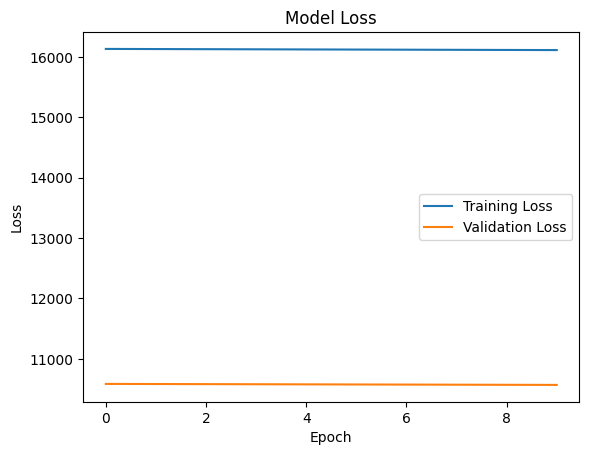

In [219]:
# Plotting training history
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [220]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_std)
    test_loss = criterion(test_outputs, Y_test).item()
    print("Test Loss:", test_loss)

Test Loss: 10568.59375
